# Personalized Travel Destinations

### IBM Applied Data Science Capstone on Coursera

This notebook is a proof of concept exercise looking at whether venue data from foursquare.com and additional data collected on climate, population and topography elsewhere can used to group (cluster) locations and potentaily identify interesting an novel connections for travel destinations.  This is a small scale test using methods that should be able to scale up to a larger test and production if successful.

This is a working document, not a report.  Please look at the report for finals results and discussion that were accpeted as the final outcome of the work in here.  This is the interactive work area where various ideas were tried out, so there is something of a debris trail from that.  At any given point in time, it should run all the way through - although occasionally a piece may have changed that breaks one or two code blocks.  If we wanted to do that tidier we would be working in R Studio!

First we need to load the various libraries use in the study.

In [1]:
import pandas as pd
import numpy as np
import json
import math

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
from matplotlib import pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

The following CSV file is the compiled locations, topography and climate data for the 36 locations used in the study.  Locations are not random and have been selected to ensure both similarity and difference between locations.

In [2]:
locations = pd.read_csv("Locations3.csv")
locations

,Name,Country,Lat,Long,Elev,Pop,Terrain,Avg Temp,Min Temp,Max Temp,Ann Ppt,MinM Ppt,MaxM Ppt,Note
0,Limerick1,Ireland,52.661817,-8.633885,4,94192,Inland Flat,10.1,2.8,19.5,981,59,112,NaN
1,Limerick2,Ireland,52.669951,-8.627474,4,94192,Inland Flat,10.1,2.8,19.5,981,59,112,NaN
2,Dublin1,Ireland,53.342951,-6.258419,13,1388000,Coastal Flat,9.7,2.4,19.4,767,52,80,Costa by Trinity
3,Dublin2,Ireland,53.329105,-6.234756,6,1388000,Coastal Flat,9.7,2.4,19.4,767,52,80,Ballsbridge
4,Dublin3,Ireland,53.339688,-6.237375,10,1388000,Coastal Flat,9.7,2.4,19.4,767,52,80,GC Dock - Aviva
5,Lahinch,Ireland,52.931830,-9.346620,6,638,Coastal Flat,9.9,2.5,18.6,1153,63,137,Doolin weather
6,Wexford,Ireland,52.339532,-6.468233,23,20188,Coastal Flat,10.1,3.1,19.0,941,55,104,NaN
7,Newcastle1,England,54.969690,-1.610758,30,268064,Coastal Flat,8.5,3.0,18.8,655,44,71,Quatside
8,Newcastle2,NaN,54.977252,-1.626508,56,268064,Coastal Flat,8.5,3.0,18.8,655,44,71,St James Park
9,Newcastle3,NaN,55.021363,-1.435278,12,67519,Coastal Flat,8.5,3.0,18.8,655,44,71,Tynemouth


## Location data 
Location data was compiled from a selected group of locations for proof of concept.  Latitude and longitude was 
collected manually from inspecting Google Maps for suitable location centres.  The elevation of these sites was
determined using Elevation Finder (https://www.freemaptools.com/elevation-finder.htm).  Populations were found by
Google searches and are a recent population estiamte - within the last 5 years.  They are of the metropolitan area,
if there is one for the location.  Four classifications of terrain were made to seperate coastal and inland sites with hilly (mountainous) and flat topography.

In [3]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

### Venue Data
Setting up for calls to foursquare.com to collect venure data in a 500m radius of the selected locations.  Check output each step through to confirm functio.

In [4]:
CLIENT_ID = 'ED44TJOWXHIZ1DRYONSCSN3KI0GWW1HJLCHVXNCV2COL0RUL' # your Foursquare ID
CLIENT_SECRET = 'HOQT5SNOO04NGNMRGCLLLDKBI5LFYZJFWXM3QSL4KMOUHTPG' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ED44TJOWXHIZ1DRYONSCSN3KI0GWW1HJLCHVXNCV2COL0RUL
CLIENT_SECRET:HOQT5SNOO04NGNMRGCLLLDKBI5LFYZJFWXM3QSL4KMOUHTPG


In [5]:
n=20
locations.loc[n, 'Name']

'Vancouver2'

In [6]:
latitude = locations.loc[n, 'Lat'] # neighborhood latitude value
longitude = locations.loc[n, 'Long'] # neighborhood longitude value

location_name = locations.loc[n, 'Name'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(location_name, 
                                                               latitude, 
                                                               longitude))

Latitude and longitude values of Vancouver2 are 49.272703799999995, -123.1588173.


We need to limit how much data we collect.  Radius of 500m should be enough to find a decent set of venues but not too much so that the location becomes blurred with adjacent, potentially different areas.

In [8]:
radius = 500 # define radius
LIMIT = 100 # limit of number of venues returned by Foursquare API

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
#url

In [9]:
results = requests.get(url).json()

venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues

,name,categories,lat,lng
0,Kitsilano Public Pool,Pool,49.273215,-123.157413
1,Kitsilano Beach,Beach,49.273559,-123.154570
2,Local Kitsilano,New American Restaurant,49.272481,-123.155240
3,Nook,Italian Restaurant,49.272248,-123.155165
4,MAK N MING,Asian Restaurant,49.271230,-123.155032
5,Viva Fine Foods,Bakery,49.272060,-123.155031
6,Chewies Steam & Oyster Bar Kitsilano,Seafood Restaurant,49.270940,-123.155168
7,Raisu,Japanese Restaurant,49.268244,-123.158430
8,Kibune Sushi,Sushi Restaurant,49.272513,-123.155003
9,Trafalgar Beach,Beach,49.273860,-123.164314


Having a look at the venue data returned for one location.

In [10]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

30 venues were returned by Foursquare.


In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            len(results),
            v['venue']['name'],
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'], 
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Name', 
                  'Location Lat', 
                  'Location Long', 
                  'Count',
                  'Venue', 
                  'Venue Lat', 
                  'Venue Long', 
                  'Venue Category']
    
    return(nearby_venues)

## Get Main Venue Data

Now that we are happy this looks like its working - get the full list of venues for processing into something we can do clustering with.  First step is to loop through calls to foursquare.com and this takes a little time.  Tach location is printed as its done as an activity marker.  Take a quick look at something we got to make sure we are getting what we expect.

In [12]:
all_venues = getNearbyVenues(names=locations['Name'],
                                   latitudes=locations['Lat'],
                                   longitudes=locations['Long']
                                  )

print(all_venues.shape)
print(all_venues.head())

print('There are {} uniques categories.'.format(len(all_venues['Venue Category'].unique())))

#all_venues.groupby('Name').count()
all_venues

Limerick1
Limerick2
Dublin1
Dublin2
Dublin3
Lahinch
Wexford
Newcastle1
Newcastle2
Newcastle3
Matlock
Buenos Aires1
Buenos Aires2
Buenos Aires3
Salta1
Salta2
Salta3
San Juan
Mendoza
Vancouver1
Vancouver2
Vancouver3
Vancouver5
Vancouver6
Smithers
Madrid
Sevilla
Huelva
Cork
Athlone
Vancouver4
Victoria
Vernon
Kelowna
Howth
Waterford
(1591, 8)
        Name  Location Lat  Location Long  Count             Venue  Venue Lat  \
0  Limerick1     52.661817      -8.633885     32      French Table  52.660784   
1  Limerick1     52.661817      -8.633885     32           Canteen  52.659937   
2  Limerick1     52.661817      -8.633885     32    House Limerick  52.663111   
3  Limerick1     52.661817      -8.633885     32  La Cucina Centro  52.662800   
4  Limerick1     52.661817      -8.633885     32          Taikichi  52.662304   

   Venue Long       Venue Category  
0   -8.635269    French Restaurant  
1   -8.630052                 Café  
2   -8.631015               Lounge  
3   -8.629792           

,Name,Location Lat,Location Long,Count,Venue,Venue Lat,Venue Long,Venue Category
0,Limerick1,52.661817,-8.633885,32,French Table,52.660784,-8.635269,French Restaurant
1,Limerick1,52.661817,-8.633885,32,Canteen,52.659937,-8.630052,Café
2,Limerick1,52.661817,-8.633885,32,House Limerick,52.663111,-8.631015,Lounge
3,Limerick1,52.661817,-8.633885,32,La Cucina Centro,52.662800,-8.629792,Restaurant
4,Limerick1,52.661817,-8.633885,32,Taikichi,52.662304,-8.628358,Japanese Restaurant
...,...,...,...,...,...,...,...,...
1586,Waterford,52.259887,-7.115541,34,Kazbar,52.258131,-7.111697,Pub
1587,Waterford,52.259887,-7.115541,34,Dunnes Stores,52.260255,-7.110006,Supermarket
1588,Waterford,52.259887,-7.115541,34,Dooley's Hotel,52.262812,-7.115583,Hotel
1589,Waterford,52.259887,-7.115541,34,Edmund Rice International Heritage Centre,52.257034,-7.117016,History Museum


### One Hot Encoding 

We need to convert from a list of venues for each location to something we can work with.  This is done by a method called *one hot encoding* which converts the list into columns for each unique item in the list.  Each column eill contain a count for that venue type at the location.  This can now be converted in proprotions which are better for processing.  By using proportions (rather than count) for each venure type we have all the venues porportions summing to 1 for each location.  Proportions avoid the problem of differnet venue counts between locations.  It also helps to keep scale of differnt contributing parameteres witin a similar range.  Normalization is not needed or appropriate with this form of representing the data.

In [13]:
# one hot encoding
venues_onehot = pd.get_dummies(all_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
venues_onehot['Name'] = all_venues['Name'] 

# move neighborhood column to the first column
fixed_columns = [venues_onehot.columns[-1]] + list(venues_onehot.columns[:-1])
venues_onehot = venues_onehot[fixed_columns]

print(venues_onehot.head())

print(venues_onehot.shape)

venues_grouped = venues_onehot.groupby('Name').mean().reset_index()

venues_diversity = all_venues.groupby('Name')['Venue Category'].nunique()


        Name  Accessories Store  American Restaurant  Arepa Restaurant  \
0  Limerick1                  0                    0                 0   
1  Limerick1                  0                    0                 0   
2  Limerick1                  0                    0                 0   
3  Limerick1                  0                    0                 0   
4  Limerick1                  0                    0                 0   

   Argentinian Restaurant  Art Gallery  Art Museum  Arts & Crafts Store  \
0                       0            0           0                    0   
1                       0            0           0                    0   
2                       0            0           0                    0   
3                       0            0           0                    0   
4                       0            0           0                    0   

   Asian Restaurant  Australian Restaurant  ...  Video Store  \
0                 0                     

In [14]:
venues_grouped.shape

(36, 213)

In [15]:
locations.head()

,Name,Country,Lat,Long,Elev,Pop,Terrain,Avg Temp,Min Temp,Max Temp,Ann Ppt,MinM Ppt,MaxM Ppt,Note
0,Limerick1,Ireland,52.661817,-8.633885,4,94192,Inland Flat,10.1,2.8,19.5,981,59,112,NaN
1,Limerick2,Ireland,52.669951,-8.627474,4,94192,Inland Flat,10.1,2.8,19.5,981,59,112,NaN
2,Dublin1,Ireland,53.342951,-6.258419,13,1388000,Coastal Flat,9.7,2.4,19.4,767,52,80,Costa by Trinity
3,Dublin2,Ireland,53.329105,-6.234756,6,1388000,Coastal Flat,9.7,2.4,19.4,767,52,80,Ballsbridge
4,Dublin3,Ireland,53.339688,-6.237375,10,1388000,Coastal Flat,9.7,2.4,19.4,767,52,80,GC Dock - Aviva


## Feature Engineering

A little light feature engineering is used to consilidate climate and topography.  In addition, venue density (the count returned by the search) and diversity (the number of unique venue types over the venure count)  are also used to develop parameters that characterize locations for clsutering.  We check one of these parameters to see it working and has been normalized.

In [16]:
locations.sort_values(by='Name', inplace=True)
locations.reset_index(inplace=True)

maxlogpop = np.log10(locations['Pop'].max())
maxlogelev = np.log10(locations['Elev'].max())

log_pop = np.log10(locations['Pop']) / maxlogpop
log_elev = np.log10(locations['Elev']) / maxlogelev

maxtemp = locations['Avg Temp'].max()
mintemp = locations['Avg Temp'].min()
normtemp = (locations['Avg Temp'] - mintemp) / (maxtemp - mintemp)

maxppt = locations['Ann Ppt'].max()
minppt = locations['Ann Ppt'].min()
normppt = (locations['Ann Ppt'] - minppt) / (maxppt - minppt)

rangetemp = locations['Max Temp'] - locations['Min Temp']
rangetemp = (rangetemp - rangetemp.min()) / (rangetemp.max() - rangetemp.min())

rangeppt = locations['MaxM Ppt'] - locations['MinM Ppt']
rangeppt = (rangeppt - rangeppt.min()) / (rangeppt.max() - rangeppt.min()) 

locations.head()

,index,Name,Country,Lat,Long,Elev,Pop,Terrain,Avg Temp,Min Temp,Max Temp,Ann Ppt,MinM Ppt,MaxM Ppt,Note
0,29,Athlone,Ireland,53.424288,-7.940410,43,21351,Inland Flat,9.2,1.6,18.9,931,57,97,NaN
1,11,Buenos Aires1,Argentina,-34.607186,-58.374550,6,15594428,Coastal Flat,16.8,6.5,29.2,1040,59,115,El Dique
2,12,Buenos Aires2,Argentina,-34.581220,-58.427765,11,15594428,Coastal Flat,16.8,6.5,29.2,1040,59,115,Palermo
3,13,Buenos Aires3,Argentina,-34.635090,-58.372564,16,15594428,Coastal Flat,16.8,6.5,29.2,1040,59,115,La Boca
4,28,Cork,Ireland,51.899487,-8.473727,4,124391,Coastal Cliffs,10.4,3.7,18.9,1055,59,119,NaN


In [17]:
rangeppt

0     0.136095
1     0.230769
2     0.230769
3     0.230769
4     0.254438
5     0.065089
6     0.065089
7     0.065089
8     0.065089
9     0.331361
10    0.000000
11    0.337278
12    0.213018
13    0.213018
14    0.177515
15    0.112426
16    0.065089
17    0.059172
18    0.059172
19    0.059172
20    0.923077
21    0.923077
22    0.923077
23    0.005917
24    0.408284
25    0.177515
26    0.857988
27    0.857988
28    0.857988
29    0.857988
30    1.000000
31    0.970414
32    0.065089
33    0.289941
34    0.183432
35    0.189349
dtype: float64

### Checking engineered component of data

Finish up gathering the engineered data and have a look to make sure ranges are good and no other surprises.  This is also a good place to get a sense of the venue and climate charracteristics across the locations.

In [19]:
venues_dens = all_venues.groupby('Name')['Venue Category'].count() /100
#don't normalize venue density since it is already close enough (count range 5 to 100 divided by 100)

venues_div = 1 - venues_diversity / all_venues.groupby('Name')['Venue Category'].count()
#normalize venue diversity
venues_div = (venues_div - venues_div.min()) / (venues_div.max() - venues_div.min()) 

names = venues_grouped['Name']

frame = pd.DataFrame(names).reset_index()

venues_dens.rename("density", inplace=True)
#venues_div.rename("diversity", inplace=True)
venues_div.rename("homogeneity", inplace=True)

frame = pd.merge(frame, venues_dens, on="Name")
frame = pd.merge(frame, venues_div, on="Name")
#frame.rename({"Venue Category_x":"density", "Venue Category_y":"diversity"}, inplace=True)

frame['log elev'] = log_elev
frame['log pop'] = log_pop
frame['ntemp'] = normtemp
frame['rangetemp'] = rangetemp
frame['nppt'] = normppt
frame['rangeppt'] = rangeppt

frame.to_csv("Engineered1.csv") # Dump a coy for debugging or review in excel or other software.

frame

,index,Name,density,homogeneity,log elev,log pop,ntemp,rangetemp,nppt,rangeppt
0,0,Athlone,0.24,0.607759,0.533560,0.601896,0.360544,0.102439,0.595306,0.136095
1,1,Buenos Aires1,1.00,0.875172,0.254177,1.000000,0.877551,0.365854,0.672831,0.230769
2,2,Buenos Aires2,1.00,0.615862,0.340163,1.000000,0.877551,0.365854,0.672831,0.230769
3,3,Buenos Aires3,0.31,0.679644,0.393317,1.000000,0.877551,0.365854,0.672831,0.230769
4,4,Cork,1.00,0.972414,0.196658,0.708301,0.442177,0.000000,0.683499,0.254438
5,5,Dublin1,0.76,0.682396,0.363861,0.853943,0.394558,0.087805,0.478663,0.065089
6,6,Dublin2,0.34,0.619675,0.254177,0.853943,0.394558,0.087805,0.478663,0.065089
7,7,Dublin3,0.48,0.742816,0.326642,0.853943,0.394558,0.087805,0.478663,0.065089
8,8,Howth,0.24,0.472701,0.444798,0.547732,0.394558,0.087805,0.478663,0.065089
9,9,Huelva,0.41,0.790580,0.326642,0.795194,0.945578,0.321951,0.265292,0.331361


In [20]:
frame.drop('index', axis=1, inplace=True)


In [21]:
num_top_venues = 5

for hood in venues_grouped['Name']:
    print("----"+hood+"----")
    temp = venues_grouped[venues_grouped['Name'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Athlone----
         venue  freq
0  Coffee Shop  0.17
1          Pub  0.12
2        Hotel  0.12
3          Bar  0.08
4   Restaurant  0.08


----Buenos Aires1----
                    venue  freq
0             Coffee Shop  0.15
1                   Hotel  0.09
2  Argentinian Restaurant  0.07
3                    Café  0.06
4              Restaurant  0.05


----Buenos Aires2----
                    venue  freq
0                   Hotel  0.09
1  Argentinian Restaurant  0.09
2             Pizza Place  0.04
3          Ice Cream Shop  0.04
4                    Café  0.03


----Buenos Aires3----
            venue  freq
0            Café  0.13
1     Pizza Place  0.10
2  Ice Cream Shop  0.10
3          Bakery  0.10
4     Supermarket  0.06


----Cork----
          venue  freq
0           Pub  0.18
1          Café  0.13
2   Coffee Shop  0.07
3    Restaurant  0.06
4  Burger Joint  0.06


----Dublin1----
         venue  freq
0          Pub  0.13
1  Coffee Shop  0.11
2         Café  0.07
3        

In [22]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Although we neded up not using it directly we also calculate the top ten most common venues around the location.  I believe this information will be captured in the second pass using a dimension reduction method.  One thing that comes out here is "Pub" is usually top of the list in Ireland - no surprise!  But also there are multiple venue types that are only slightly different.  Future work could explore ways to consoidate things like pub, bar and beer bar.

In [23]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
locations_venues_sorted = pd.DataFrame(columns=columns)
locations_venues_sorted['Name'] = venues_grouped['Name']

for ind in np.arange(venues_grouped.shape[0]):
    locations_venues_sorted.iloc[ind, 1:] = return_most_common_venues(venues_grouped.iloc[ind, :], num_top_venues)

locations_venues_sorted.head()

,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Athlone,Coffee Shop,Pub,Hotel,Bar,Restaurant,Train Station,Café,Shopping Mall,Castle,Bistro
1,Buenos Aires1,Coffee Shop,Hotel,Argentinian Restaurant,Café,Restaurant,Sandwich Place,Historic Site,Bookstore,Burger Joint,Vegetarian / Vegan Restaurant
2,Buenos Aires2,Argentinian Restaurant,Hotel,Pizza Place,Ice Cream Shop,Italian Restaurant,Café,Brewery,Beer Bar,Bar,Clothing Store
3,Buenos Aires3,Café,Ice Cream Shop,Pizza Place,Bakery,Plaza,Fish Market,BBQ Joint,Supermarket,Yoga Studio,Thrift / Vintage Store
4,Cork,Pub,Café,Coffee Shop,Restaurant,Burger Joint,Bar,French Restaurant,Department Store,Bookstore,Clothing Store


## Pass One

### Location k-Means Clustering

Lets do some clustering and see what results.  Make some adjustments and then do a scond pass to see how different adjustments affect the reuslts.  (Repeat as needed in study.)

In [24]:
venues_grouped = pd.merge(venues_grouped, frame, on="Name")
venues_grouped

,Name,Accessories Store,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Australian Restaurant,...,Women's Store,Yoga Studio,density,homogeneity,log elev,log pop,ntemp,rangetemp,nppt,rangeppt
0,Athlone,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.24,0.607759,0.533560,0.601896,0.360544,0.102439,0.595306,0.136095
1,Buenos Aires1,0.000000,0.000000,0.00,0.070000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.00,0.875172,0.254177,1.000000,0.877551,0.365854,0.672831,0.230769
2,Buenos Aires2,0.000000,0.000000,0.01,0.090000,0.010000,0.000000,0.000000,0.000000,0.000000,...,0.010000,0.010000,1.00,0.615862,0.340163,1.000000,0.877551,0.365854,0.672831,0.230769
3,Buenos Aires3,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.032258,0.31,0.679644,0.393317,1.000000,0.877551,0.365854,0.672831,0.230769
4,Cork,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,...,0.000000,0.000000,1.00,0.972414,0.196658,0.708301,0.442177,0.000000,0.683499,0.254438
5,Dublin1,0.000000,0.013158,0.00,0.000000,0.000000,0.013158,0.013158,0.000000,0.000000,...,0.000000,0.000000,0.76,0.682396,0.363861,0.853943,0.394558,0.087805,0.478663,0.065089
6,Dublin2,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.029412,0.000000,...,0.000000,0.000000,0.34,0.619675,0.254177,0.853943,0.394558,0.087805,0.478663,0.065089
7,Dublin3,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.020833,0.48,0.742816,0.326642,0.853943,0.394558,0.087805,0.478663,0.065089
8,Howth,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.24,0.472701,0.444798,0.547732,0.394558,0.087805,0.478663,0.065089
9,Huelva,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.41,0.790580,0.326642,0.795194,0.945578,0.321951,0.265292,0.331361


In [25]:
venues_grouped_clustering = venues_grouped.drop('Name', 1)

In [26]:
# set number of clusters
kclusters = 5

#venues_grouped.join(locations , on='Name')
venues_grouped_clustering = venues_grouped.drop('Name', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(venues_grouped_clustering)

# check cluster labels generated for each row in the dataframe
# kmeans.labels_[0:10] 

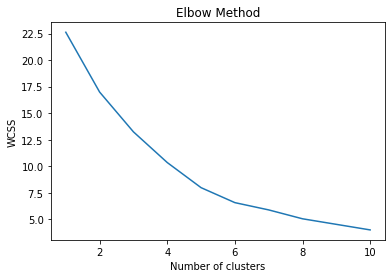

In [27]:
#venues_grouped_clustering = venues_grouped.drop('Name', 1)

wcss = []
for i in range(1, 11):
    kmeans2 = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans2.fit(venues_grouped_clustering)
    wcss.append(kmeans2.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### How many clusters?

Maybe if you squint right you could make a case for 6 clusters rom the elbow plot.  Five slusters seems to make better sense based on interpretation of the association of locations.  Four might be even better, but there is a characteristic that shows up in five clusters that is useful for interpretation.

In [28]:
venues_grouped_clustering

,Accessories Store,American Restaurant,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Australian Restaurant,BBQ Joint,...,Women's Store,Yoga Studio,density,homogeneity,log elev,log pop,ntemp,rangetemp,nppt,rangeppt
0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.24,0.607759,0.533560,0.601896,0.360544,0.102439,0.595306,0.136095
1,0.000000,0.000000,0.00,0.070000,0.000000,0.000000,0.000000,0.000000,0.000000,0.010000,...,0.000000,0.000000,1.00,0.875172,0.254177,1.000000,0.877551,0.365854,0.672831,0.230769
2,0.000000,0.000000,0.01,0.090000,0.010000,0.000000,0.000000,0.000000,0.000000,0.010000,...,0.010000,0.010000,1.00,0.615862,0.340163,1.000000,0.877551,0.365854,0.672831,0.230769
3,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.064516,...,0.000000,0.032258,0.31,0.679644,0.393317,1.000000,0.877551,0.365854,0.672831,0.230769
4,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.00,0.972414,0.196658,0.708301,0.442177,0.000000,0.683499,0.254438
5,0.000000,0.013158,0.00,0.000000,0.000000,0.013158,0.013158,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.76,0.682396,0.363861,0.853943,0.394558,0.087805,0.478663,0.065089
6,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.029412,0.000000,0.000000,...,0.000000,0.000000,0.34,0.619675,0.254177,0.853943,0.394558,0.087805,0.478663,0.065089
7,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.020833,0.48,0.742816,0.326642,0.853943,0.394558,0.087805,0.478663,0.065089
8,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.24,0.472701,0.444798,0.547732,0.394558,0.087805,0.478663,0.065089
9,0.000000,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.41,0.790580,0.326642,0.795194,0.945578,0.321951,0.265292,0.331361


In [29]:
# add clustering labels
locations_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Finally we can take a look at the label column and see how clusters are shaping up.

In [30]:
#locations_venues_sorted.head()
locations_venues_sorted

,Cluster Labels,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,Athlone,Coffee Shop,Pub,Hotel,Bar,Restaurant,Train Station,Café,Shopping Mall,Castle,Bistro
1,3,Buenos Aires1,Coffee Shop,Hotel,Argentinian Restaurant,Café,Restaurant,Sandwich Place,Historic Site,Bookstore,Burger Joint,Vegetarian / Vegan Restaurant
2,3,Buenos Aires2,Argentinian Restaurant,Hotel,Pizza Place,Ice Cream Shop,Italian Restaurant,Café,Brewery,Beer Bar,Bar,Clothing Store
3,3,Buenos Aires3,Café,Ice Cream Shop,Pizza Place,Bakery,Plaza,Fish Market,BBQ Joint,Supermarket,Yoga Studio,Thrift / Vintage Store
4,3,Cork,Pub,Café,Coffee Shop,Restaurant,Burger Joint,Bar,French Restaurant,Department Store,Bookstore,Clothing Store
5,1,Dublin1,Pub,Coffee Shop,Café,Hotel,Bakery,Japanese Restaurant,Ice Cream Shop,Restaurant,Cocktail Bar,Plaza
6,1,Dublin2,Pub,Coffee Shop,Indian Restaurant,Thai Restaurant,Café,Pizza Place,Italian Restaurant,Hotel,Nail Salon,Optical Shop
7,1,Dublin3,Pub,Coffee Shop,Café,Bar,Hotel,Plaza,Gym / Fitness Center,Pizza Place,Gastropub,Farmers Market
8,1,Howth,Seafood Restaurant,Ice Cream Shop,Café,Pub,Bar,Hungarian Restaurant,Train Station,Mexican Restaurant,Coffee Shop,Gastropub
9,3,Huelva,Spanish Restaurant,Tapas Restaurant,Bar,Restaurant,Clothing Store,Plaza,Ice Cream Shop,Pub,Burger Joint,Garden


## Visualization of Pass One

First we need to connect the coordinate data to results of the clustering.  Lets make a map and colour by cluster label.

In [31]:
locations_merged = locations

locations_merged = locations_merged.join(locations_venues_sorted.set_index('Name'), on='Name')

locations_merged.head() # check the last columns!

,index,Name,Country,Lat,Long,Elev,Pop,Terrain,Avg Temp,Min Temp,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,29,Athlone,Ireland,53.424288,-7.940410,43,21351,Inland Flat,9.2,1.6,...,Coffee Shop,Pub,Hotel,Bar,Restaurant,Train Station,Café,Shopping Mall,Castle,Bistro
1,11,Buenos Aires1,Argentina,-34.607186,-58.374550,6,15594428,Coastal Flat,16.8,6.5,...,Coffee Shop,Hotel,Argentinian Restaurant,Café,Restaurant,Sandwich Place,Historic Site,Bookstore,Burger Joint,Vegetarian / Vegan Restaurant
2,12,Buenos Aires2,Argentina,-34.581220,-58.427765,11,15594428,Coastal Flat,16.8,6.5,...,Argentinian Restaurant,Hotel,Pizza Place,Ice Cream Shop,Italian Restaurant,Café,Brewery,Beer Bar,Bar,Clothing Store
3,13,Buenos Aires3,Argentina,-34.635090,-58.372564,16,15594428,Coastal Flat,16.8,6.5,...,Café,Ice Cream Shop,Pizza Place,Bakery,Plaza,Fish Market,BBQ Joint,Supermarket,Yoga Studio,Thrift / Vintage Store
4,28,Cork,Ireland,51.899487,-8.473727,4,124391,Coastal Cliffs,10.4,3.7,...,Pub,Café,Coffee Shop,Restaurant,Burger Joint,Bar,French Restaurant,Department Store,Bookstore,Clothing Store


In [32]:
#locations_merged

,index,Name,Country,Lat,Long,Elev,Pop,Terrain,Avg Temp,Min Temp,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,29,Athlone,Ireland,53.424288,-7.940410,43,21351,Inland Flat,9.2,1.6,...,Coffee Shop,Pub,Hotel,Bar,Restaurant,Train Station,Café,Shopping Mall,Castle,Bistro
1,11,Buenos Aires1,Argentina,-34.607186,-58.374550,6,15594428,Coastal Flat,16.8,6.5,...,Coffee Shop,Hotel,Argentinian Restaurant,Café,Restaurant,Sandwich Place,Historic Site,Bookstore,Burger Joint,Vegetarian / Vegan Restaurant
2,12,Buenos Aires2,Argentina,-34.581220,-58.427765,11,15594428,Coastal Flat,16.8,6.5,...,Argentinian Restaurant,Hotel,Pizza Place,Ice Cream Shop,Italian Restaurant,Café,Brewery,Beer Bar,Bar,Clothing Store
3,13,Buenos Aires3,Argentina,-34.635090,-58.372564,16,15594428,Coastal Flat,16.8,6.5,...,Café,Ice Cream Shop,Pizza Place,Bakery,Plaza,Fish Market,BBQ Joint,Supermarket,Yoga Studio,Thrift / Vintage Store
4,28,Cork,Ireland,51.899487,-8.473727,4,124391,Coastal Cliffs,10.4,3.7,...,Pub,Café,Coffee Shop,Restaurant,Burger Joint,Bar,French Restaurant,Department Store,Bookstore,Clothing Store
5,2,Dublin1,Ireland,53.342951,-6.258419,13,1388000,Coastal Flat,9.7,2.4,...,Pub,Coffee Shop,Café,Hotel,Bakery,Japanese Restaurant,Ice Cream Shop,Restaurant,Cocktail Bar,Plaza
6,3,Dublin2,Ireland,53.329105,-6.234756,6,1388000,Coastal Flat,9.7,2.4,...,Pub,Coffee Shop,Indian Restaurant,Thai Restaurant,Café,Pizza Place,Italian Restaurant,Hotel,Nail Salon,Optical Shop
7,4,Dublin3,Ireland,53.339688,-6.237375,10,1388000,Coastal Flat,9.7,2.4,...,Pub,Coffee Shop,Café,Bar,Hotel,Plaza,Gym / Fitness Center,Pizza Place,Gastropub,Farmers Market
8,34,Howth,Ireland,53.386210,-6.074880,23,8706,Coastal Cliffs,9.7,2.4,...,Seafood Restaurant,Ice Cream Shop,Café,Pub,Bar,Hungarian Restaurant,Train Station,Mexican Restaurant,Coffee Shop,Gastropub
9,27,Huelva,Spain,37.257786,-6.954518,10,524576,Coastal Flat,17.8,7.7,...,Spanish Restaurant,Tapas Restaurant,Bar,Restaurant,Clothing Store,Plaza,Ice Cream Shop,Pub,Burger Joint,Garden


In [33]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=1)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(5)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(locations_merged['Lat'], locations_merged['Long'], locations_merged['Name'], locations_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[math.floor(cluster)],
        fill=True,
        fill_color=rainbow[math.floor(cluster)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### PCA scatter plot

It can be useful to review PCA plots of PC1 versus PC2 and see how clusters look in that space.  They should seperate out since PCA should be pulling out the linear combination of parameters that account for as much variance as possible.  Clustering should show up as similarly coded reagions in PC1 PC2 space.  And they do.  This is a useful plot to help with interpreting what the clusters represent in the underlying data.  

Since we are here, check the eigen values to get the amount of variance explained in each componeent (we only look at the first two here) and eigen vectors to get a sense of which parameters are providing the greatest incluence for PC1 and PC2.

In [34]:
pca = PCA(2)
pca.fit(venues_grouped_clustering)
projected = pca.fit_transform(venues_grouped_clustering)
print(projected.shape)

print(pca.explained_variance_)

(36, 2)
[0.1996097  0.15363941]


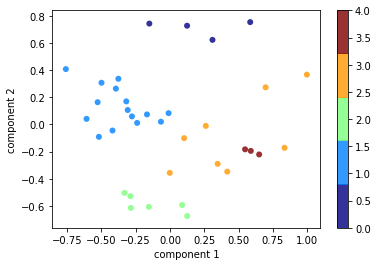

In [35]:
plt.scatter(projected[:, 0], projected[:, 1],
            c=kmeans.labels_, edgecolor='none', alpha=0.8,
            cmap=plt.cm.get_cmap('jet', 5))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

In [36]:
print(pca.components_)

[[ 1.88008960e-04 -2.53827340e-03  4.97865480e-04  6.41546583e-02
  -2.77931991e-04  5.33524704e-03  6.40321224e-05 -4.95859696e-03
   1.88008960e-04  4.61289542e-03  6.19692484e-03 -2.70653962e-03
  -1.86161950e-02  4.97865480e-04 -9.34786345e-03  2.73532633e-03
   3.66813120e-03  3.84161910e-03  1.88008960e-04  4.97865480e-04
   4.12883921e-03 -4.62721728e-03 -5.87788511e-04  9.73076806e-04
   6.69004435e-04  1.10822574e-02  5.90520265e-04 -2.35006738e-04
   2.80641366e-03 -1.80310092e-05 -1.37269145e-03 -1.19670463e-03
   4.97865480e-04 -3.39513154e-02  1.19567222e-03  5.03470180e-04
  -1.29305248e-02 -1.22815833e-04 -2.39385534e-03  3.14855220e-03
   7.46274873e-04  3.35451474e-03  5.14629685e-03 -2.46784262e-02
  -1.22815833e-04  1.41116360e-03  1.42803360e-03 -1.39685838e-04
  -3.73339833e-04 -3.69006857e-03 -1.29421421e-03 -5.44604060e-04
  -6.09787616e-04  5.97836112e-04  3.44203065e-04 -3.47609690e-03
  -2.26908172e-03  8.78251023e-03 -1.77423060e-03 -3.44728828e-03
   1.97590

In [37]:
venues_grouped.shape

(36, 221)

In [38]:
col_list= list(venues_grouped)

In [41]:
#x = ['Name', 'density', 'diversity', 'log elev', 'log pop', 'ntemp', 'rangetemp', 'nppt', 'rangeppt']
#for col in x:
#    col_list.remove(col)
#x

In [43]:
# col_list

## Pass Two: use PCA to consolidate venues

Lets look at using PCA to consolidate the large number of columns (220 columns!) resulting from the one hot encoding of the venue counts.  If we use PCA to reduce dimensionality how many parameters do we really need?

In [42]:
pca2 = PCA(10)
pca2.fit(venues_grouped_clustering)
projected = pca2.fit_transform(venues_grouped_clustering)
print(projected.shape)

print(pca2.explained_variance_)

(36, 10)
[0.1996097  0.15363941 0.14239416 0.05637593 0.02934325 0.01331316
 0.00981228 0.00945623 0.00596198 0.00376982]


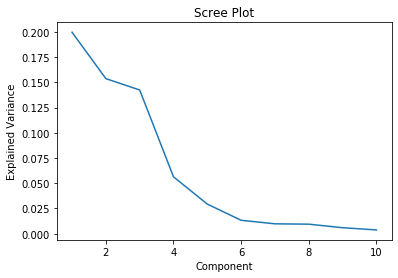

In [44]:
plt.plot(range(1, 11), pca2.explained_variance_)
plt.title('Scree Plot')
plt.xlabel('Component')
plt.ylabel('Explained Variance')
plt.show()

The scree plot is quite clear that after 6 compnents the amount of variance left to account for is small and only decreses alightly each additional component.  We will use 10 components - a massive reduction from the original 220 parameters!

We want to use the first 10 components of the transformed venue data as the venue part of the data to cluster in pass two.  The location and other data (climate and topography) has not changed so we can just combine that again before processing.  The rest of the clustering is the same as pass one.

In [45]:
frame_pca = pd.DataFrame(pca2.transform(venues_grouped_clustering))
frame_pca.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.317549,0.170104,0.116199,-0.128580,-0.212553,0.083593,0.056395,0.117309,-0.034958,-0.013006
1,0.417669,-0.347983,0.565233,0.087650,0.208459,-0.042749,0.020569,0.134067,-0.065883,-0.081253
2,0.347826,-0.290407,0.427775,0.156327,0.277718,-0.191687,-0.055024,0.151793,0.028390,-0.089623
3,0.103681,-0.100980,0.102884,-0.244077,0.344640,-0.010845,0.175932,0.145205,-0.124213,0.130616
4,-0.000811,-0.356816,0.733908,0.132821,-0.214903,0.057802,-0.147139,-0.013232,-0.070397,0.057784


In [46]:
frame2 = pd.concat([frame, frame_pca], axis=1)
frame2.head()

,Name,density,homogeneity,log elev,log pop,ntemp,rangetemp,nppt,rangeppt,0,1,2,3,4,5,6,7,8,9
0,Athlone,0.24,0.607759,0.533560,0.601896,0.360544,0.102439,0.595306,0.136095,-0.317549,0.170104,0.116199,-0.128580,-0.212553,0.083593,0.056395,0.117309,-0.034958,-0.013006
1,Buenos Aires1,1.00,0.875172,0.254177,1.000000,0.877551,0.365854,0.672831,0.230769,0.417669,-0.347983,0.565233,0.087650,0.208459,-0.042749,0.020569,0.134067,-0.065883,-0.081253
2,Buenos Aires2,1.00,0.615862,0.340163,1.000000,0.877551,0.365854,0.672831,0.230769,0.347826,-0.290407,0.427775,0.156327,0.277718,-0.191687,-0.055024,0.151793,0.028390,-0.089623
3,Buenos Aires3,0.31,0.679644,0.393317,1.000000,0.877551,0.365854,0.672831,0.230769,0.103681,-0.100980,0.102884,-0.244077,0.344640,-0.010845,0.175932,0.145205,-0.124213,0.130616
4,Cork,1.00,0.972414,0.196658,0.708301,0.442177,0.000000,0.683499,0.254438,-0.000811,-0.356816,0.733908,0.132821,-0.214903,0.057802,-0.147139,-0.013232,-0.070397,0.057784


In [47]:
# set number of clusters
kclusters = 5

#venues_grouped.join(locations , on='Name')
venues_grouped_clustering3 = frame2.drop('Name', 1)

# run k-means clustering
kmeans3 = KMeans(n_clusters=kclusters, random_state=0).fit(venues_grouped_clustering3)

### Comparing first and second pass clusters

We want to load the new clusters into the venue list with locations from the first pass so we can see in that table what has changed.  Although the label numbers change somewhat, the grouping of the clusters does not change much.

When lookig at the map keep this in mind becasue the colours change, not the majority of grouping.

In [48]:
# add clustering labels
locations_venues_sorted3 = locations_venues_sorted
locations_venues_sorted3.insert(0, 'Cluster Labels3', kmeans3.labels_)

In [49]:
locations_venues_sorted3

,Cluster Labels3,Cluster Labels,Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1,1,Athlone,Coffee Shop,Pub,Hotel,Bar,Restaurant,Train Station,Café,Shopping Mall,Castle,Bistro
1,0,3,Buenos Aires1,Coffee Shop,Hotel,Argentinian Restaurant,Café,Restaurant,Sandwich Place,Historic Site,Bookstore,Burger Joint,Vegetarian / Vegan Restaurant
2,0,3,Buenos Aires2,Argentinian Restaurant,Hotel,Pizza Place,Ice Cream Shop,Italian Restaurant,Café,Brewery,Beer Bar,Bar,Clothing Store
3,1,3,Buenos Aires3,Café,Ice Cream Shop,Pizza Place,Bakery,Plaza,Fish Market,BBQ Joint,Supermarket,Yoga Studio,Thrift / Vintage Store
4,0,3,Cork,Pub,Café,Coffee Shop,Restaurant,Burger Joint,Bar,French Restaurant,Department Store,Bookstore,Clothing Store
5,1,1,Dublin1,Pub,Coffee Shop,Café,Hotel,Bakery,Japanese Restaurant,Ice Cream Shop,Restaurant,Cocktail Bar,Plaza
6,1,1,Dublin2,Pub,Coffee Shop,Indian Restaurant,Thai Restaurant,Café,Pizza Place,Italian Restaurant,Hotel,Nail Salon,Optical Shop
7,1,1,Dublin3,Pub,Coffee Shop,Café,Bar,Hotel,Plaza,Gym / Fitness Center,Pizza Place,Gastropub,Farmers Market
8,1,1,Howth,Seafood Restaurant,Ice Cream Shop,Café,Pub,Bar,Hungarian Restaurant,Train Station,Mexican Restaurant,Coffee Shop,Gastropub
9,0,3,Huelva,Spanish Restaurant,Tapas Restaurant,Bar,Restaurant,Clothing Store,Plaza,Ice Cream Shop,Pub,Burger Joint,Garden


In [50]:
locations_merged = locations

locations_merged = locations_merged.join(locations_venues_sorted3.set_index('Name'), on='Name')

locations_merged.head() # check the last columns!

,index,Name,Country,Lat,Long,Elev,Pop,Terrain,Avg Temp,Min Temp,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,29,Athlone,Ireland,53.424288,-7.940410,43,21351,Inland Flat,9.2,1.6,...,Coffee Shop,Pub,Hotel,Bar,Restaurant,Train Station,Café,Shopping Mall,Castle,Bistro
1,11,Buenos Aires1,Argentina,-34.607186,-58.374550,6,15594428,Coastal Flat,16.8,6.5,...,Coffee Shop,Hotel,Argentinian Restaurant,Café,Restaurant,Sandwich Place,Historic Site,Bookstore,Burger Joint,Vegetarian / Vegan Restaurant
2,12,Buenos Aires2,Argentina,-34.581220,-58.427765,11,15594428,Coastal Flat,16.8,6.5,...,Argentinian Restaurant,Hotel,Pizza Place,Ice Cream Shop,Italian Restaurant,Café,Brewery,Beer Bar,Bar,Clothing Store
3,13,Buenos Aires3,Argentina,-34.635090,-58.372564,16,15594428,Coastal Flat,16.8,6.5,...,Café,Ice Cream Shop,Pizza Place,Bakery,Plaza,Fish Market,BBQ Joint,Supermarket,Yoga Studio,Thrift / Vintage Store
4,28,Cork,Ireland,51.899487,-8.473727,4,124391,Coastal Cliffs,10.4,3.7,...,Pub,Café,Coffee Shop,Restaurant,Burger Joint,Bar,French Restaurant,Department Store,Bookstore,Clothing Store


In [51]:
locations_merged

,index,Name,Country,Lat,Long,Elev,Pop,Terrain,Avg Temp,Min Temp,...,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,29,Athlone,Ireland,53.424288,-7.940410,43,21351,Inland Flat,9.2,1.6,...,Coffee Shop,Pub,Hotel,Bar,Restaurant,Train Station,Café,Shopping Mall,Castle,Bistro
1,11,Buenos Aires1,Argentina,-34.607186,-58.374550,6,15594428,Coastal Flat,16.8,6.5,...,Coffee Shop,Hotel,Argentinian Restaurant,Café,Restaurant,Sandwich Place,Historic Site,Bookstore,Burger Joint,Vegetarian / Vegan Restaurant
2,12,Buenos Aires2,Argentina,-34.581220,-58.427765,11,15594428,Coastal Flat,16.8,6.5,...,Argentinian Restaurant,Hotel,Pizza Place,Ice Cream Shop,Italian Restaurant,Café,Brewery,Beer Bar,Bar,Clothing Store
3,13,Buenos Aires3,Argentina,-34.635090,-58.372564,16,15594428,Coastal Flat,16.8,6.5,...,Café,Ice Cream Shop,Pizza Place,Bakery,Plaza,Fish Market,BBQ Joint,Supermarket,Yoga Studio,Thrift / Vintage Store
4,28,Cork,Ireland,51.899487,-8.473727,4,124391,Coastal Cliffs,10.4,3.7,...,Pub,Café,Coffee Shop,Restaurant,Burger Joint,Bar,French Restaurant,Department Store,Bookstore,Clothing Store
5,2,Dublin1,Ireland,53.342951,-6.258419,13,1388000,Coastal Flat,9.7,2.4,...,Pub,Coffee Shop,Café,Hotel,Bakery,Japanese Restaurant,Ice Cream Shop,Restaurant,Cocktail Bar,Plaza
6,3,Dublin2,Ireland,53.329105,-6.234756,6,1388000,Coastal Flat,9.7,2.4,...,Pub,Coffee Shop,Indian Restaurant,Thai Restaurant,Café,Pizza Place,Italian Restaurant,Hotel,Nail Salon,Optical Shop
7,4,Dublin3,Ireland,53.339688,-6.237375,10,1388000,Coastal Flat,9.7,2.4,...,Pub,Coffee Shop,Café,Bar,Hotel,Plaza,Gym / Fitness Center,Pizza Place,Gastropub,Farmers Market
8,34,Howth,Ireland,53.386210,-6.074880,23,8706,Coastal Cliffs,9.7,2.4,...,Seafood Restaurant,Ice Cream Shop,Café,Pub,Bar,Hungarian Restaurant,Train Station,Mexican Restaurant,Coffee Shop,Gastropub
9,27,Huelva,Spain,37.257786,-6.954518,10,524576,Coastal Flat,17.8,7.7,...,Spanish Restaurant,Tapas Restaurant,Bar,Restaurant,Clothing Store,Plaza,Ice Cream Shop,Pub,Burger Joint,Garden


In [52]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=1)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(5)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(locations_merged['Lat'], locations_merged['Long'], locations_merged['Name'], locations_merged['Cluster Labels3']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[math.floor(cluster)],
        fill=True,
        fill_color=rainbow[math.floor(cluster)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Improved PC1 and PC2 components

Note that the proportion of variance from PC1 and PC2 has increased to 39.2% and 30.6% respectively so now we are getting almost 70% of the variance represented in the scatter plot.

In [53]:
pca3 = PCA(6)
pca3.fit(venues_grouped_clustering3)
projected3 = pca3.fit_transform(venues_grouped_clustering3)
print(projected3.shape)

print(pca3.explained_variance_)

(36, 6)
[0.39295577 0.30558548 0.28256564 0.10751369 0.05623459 0.02340586]


In [54]:
cluster = pd.DataFrame(kmeans3.labels_)
cluster
cluster["old"]=0
cluster.rename(columns={0:"new"}, inplace=True)

cluster.loc[(cluster['new'] == 0), "old"] = 2
cluster.loc[(cluster['new'] == 1), "old"] = 0
cluster.loc[(cluster['new'] == 2), "old"] = 4
cluster.loc[(cluster['new'] == 3), "old"] = 1
cluster.loc[(cluster['new'] == 4), "old"] = 3

#cluster

,new,old
0,1,0
1,0,2
2,0,2
3,1,0
4,0,2
5,1,0
6,1,0
7,1,0
8,1,0
9,0,2


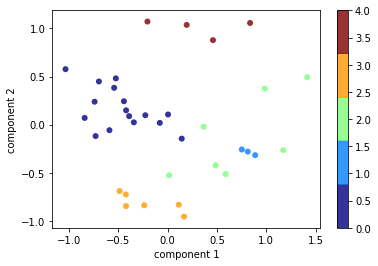

In [55]:
plt.scatter(projected3[:, 0], projected3[:, 1],
            c=cluster["old"], edgecolor='none', alpha=0.8,
            cmap=plt.cm.get_cmap('jet', 5))
plt.xlabel('component 1')
plt.ylabel('component 2')
plt.colorbar();

Finally save a coy of the second pass results for eternal review and use.

In [56]:
locations_venues_sorted3.to_csv("Location with clusters.csv")

Please read the report.